In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
import pickle

from tensorflow import keras
from keras import models, layers
from keras.models import load_model

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from qiskit.visualization import plot_histogram 
import seaborn as sns

pd.options.display.float_format = '{:,.15f}'.format

In [2]:
def NN_model(n_qubit, n_hidden_layer = 4, n_nodes = 5, activation = 'relu', d = 0.0):
    model = models.Sequential()
    model.add(layers.Dense(n_nodes * (2 ** n_qubit), activation = activation, input_shape = (2 ** n_qubit, )))

    for i in range(n_hidden_layer):
        model.add(layers.Dense(n_nodes * (2 ** n_qubit), activation = activation))
        #model.add(layers.Dropout(d))
            
    model.add(layers.Dense(2 ** n_qubit, activation = 'softmax'))
    
    return model

def transform(n_data, times, x, n_qubits):

    for i in range(times):
        for j in range(n_data):
            for k in range(2**n_qubits):
                bit_i = str(bin(k)[2:]).zfill(n_qubits)
                if bit_i not in x[i][j]:
                    x[i][j][bit_i] = 0
                if i == 0 and j == 0:
                    x[i][j][bit_i] = [x[i][j][bit_i]]

    df = pd.DataFrame(x[0][0])

    for i in range(1, n_data ):
        df = df.append(pd.Series(x[0][i], index = df.columns), ignore_index = True)
    for i in range(1, times):
        for j in range(0, n_data):
            df = df.append(pd.Series(x[i][j], index = df.columns), ignore_index = True)
    col = []
    for i in range(2**n_qubits):
        bit_i = str(bin(i)[2:]).zfill(n_qubits)
        col.append(bit_i)
    df = df[col] 
    
    return df

def load_file(n_qubits, times, device_type, number): 
    
    file_path = './' + device_type + '_' + str(n_qubits) +  'qubits_ideal_' + str(number) + '.json'
    file_path_1 = './' + device_type + '_' + str(n_qubits) + 'qubits_obs_' + str(number) + '.json'
    
    Y = 0
    with open(file_path, "r") as json_file:
        Y = json.load(json_file)
    X = 0
    with open(file_path_1, "r") as json_file:
        X = json.load(json_file)

    return X, Y

def load_data(n_qubits, n_data, times, device_type, number):

    X = [0 for i in range(len(n_qubits))]
    Y = [0 for i in range(len(n_qubits))]

    for i in range(len(n_qubits)):
        X[i], Y[i] = load_file(n_qubits[i], times[i], device_type, number)
        X[i] = transform(n_data, times[i], X[i], n_qubits[i])
        Y[i] = transform(n_data, times[i], Y[i], n_qubits[i])
        
    return X, Y

def LI_QREM(n_qubits, times, n_data, device_type, number, X):
        
    file_path_2 = './' + device_type + '_' + str(n_qubits) + 'qubits_meas_' + str(number) + '.p'
    
    with open(file_path_2, 'rb') as file:
        meas = pickle.load(file)
        
    LI = []
    for i in range(times):
        miti = []
        for j in range(n_data):
            row_dict = X.iloc[(n_data * i) + j].to_dict()
            miti.append(meas.filter.apply(row_dict))
        LI.append(miti)
    
    LI = transform(n_data, times, LI, n_qubits)

    return LI

def loss_function(p_ideal, p_mitigated, n_qubit):
    MSE = 0
    for i in range(len(p_mitigated)):
        x = 0
        for j in range(2**n_qubit):
             x += (abs(p_mitigated[i][j] - p_ideal[i][j]) ** 2)
        x /= 2**n_qubit
        MSE += x
    MSE /= len(p_mitigated)

    KLD = 0
    for i in range(len(p_mitigated)):
        x = 0
        for j in range(2**n_qubit):
            if p_ideal[i][j] < 1e-15 or p_mitigated[i][j] < 1e-15:
                x += 0
            else:
                x += p_ideal[i][j] * (math.log(p_ideal[i][j]) - math.log(p_mitigated[i][j]))
        KLD += x
    KLD /= len(p_mitigated)
    
    IF = 0
    for i in range(len(p_mitigated)):
        x = 0
        for j in range(2**n_qubit):
            x += math.sqrt(p_ideal[i][j] * p_mitigated[i][j])
        IF += (1 - x**2)
    IF /= len(p_mitigated)

    return MSE, KLD, IF

def create_x(t, w, n, d):
    return [t * x + w * n for x in range(d)]

def show_plot(topics, unmitigated, LI, NN, type = 0, label = ['unmitigated', 'LI', 'NN']):
    n = 1  # This is our first dataset (out of 2)
    t = 3 # Number of dataset
    d = 1 # Number of sets of bars
    w = 0.8 # Width of each bar

    value_a_x = create_x(t, w, 1, d)
    value_b_x = create_x(t, w, 2, d)
    value_c_x = create_x(t, w, 3, d)

    ax = plt.subplot()
    x_1 = [unmitigated[0][type]]
    x_2 = [LI[0][type]]
    x_3 = [NN[0][type]]
    ax.bar(value_a_x, x_1, label = label[0], color = 'black')
    ax.bar(value_b_x, x_2, label = label[1], color = 'white', edgecolor = 'black')
    ax.bar(value_c_x, x_3, label = label[2], color = 'white', edgecolor = 'black', hatch = '/////')

    #middle_x = [a for (a) in zip(value_a_x)]
    ax.set_xticks(value_b_x)
    ax.set_xticklabels(topics)
    plt.legend()

    img_name = ''
    if type == 0:
        plt.xlabel('(a) MSE')
        img_name = 'MSE'
    elif type == 1:
        plt.xlabel('(b) KLD')
        img_name = 'KLD'
    else:
        plt.xlabel('(c) IF')
        img_name = 'IF'

    plt.savefig('./img/'+ img_name +'.png')

    plt.show()

def get_train_test(x, y, mit, n_data, random_state = 0):
    train_x = x.sample(n_data, random_state = random_state)
    test_x = x.drop(train_x.index)

    train_y = y.sample(n_data, random_state = random_state)
    test_y = y.drop(train_y.index)

    train_miti= mit.sample(n_data, random_state = random_state)
    test_miti = mit.drop(train_miti.index)

    train_x.reset_index(drop = True, inplace = True)
    test_x.reset_index(drop = True, inplace = True)
    train_y.reset_index(drop = True, inplace = True)
    test_y.reset_index(drop = True, inplace = True)
    train_miti.reset_index(drop = True, inplace = True)
    test_miti.reset_index(drop = True, inplace = True)

    return train_x, test_x, train_y, test_y, train_miti, test_miti
    

In [3]:
n_qubits = [5]
n_data = 300 
times = [15]
device_type = "ibm_geneva"
number = 0

#n_qubits = [5]
#n_data = 900 
#times = [5]
#device_type = 'ibmq_toronto'
#number = 0

X, Y= load_data(n_qubits, n_data, times, device_type, number)
LI = LI_QREM(n_qubits[0], times[0], n_data, device_type, number, X[0])

c:\Users\ChangWon\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:70: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.


In [10]:
X[0].to_csv(device_type + '_' + str(n_qubits[0]) +  'qubits_obs_' + str(number) + '.csv', index=False, header=True)
Y[0].to_csv(device_type + '_' + str(n_qubits[0]) +  'qubits_ideal_' + str(number) + '.csv', index=False, header=True)
LI.to_csv(device_type + '_' + str(n_qubits[0]) +  'qubits_miti_' + str(number) + '.csv', index=False, header=True)

In [4]:
X = pd.read_csv(device_type + '_' + str(n_qubits[0]) +  'qubits_obs_' + str(number) + '.csv')
Y = pd.read_csv(device_type + '_' + str(n_qubits[0]) +  'qubits_ideal_' + str(number) + '.csv')
LI = pd.read_csv(device_type + '_' + str(n_qubits[0]) +  'qubits_miti_' + str(number) + '.csv')


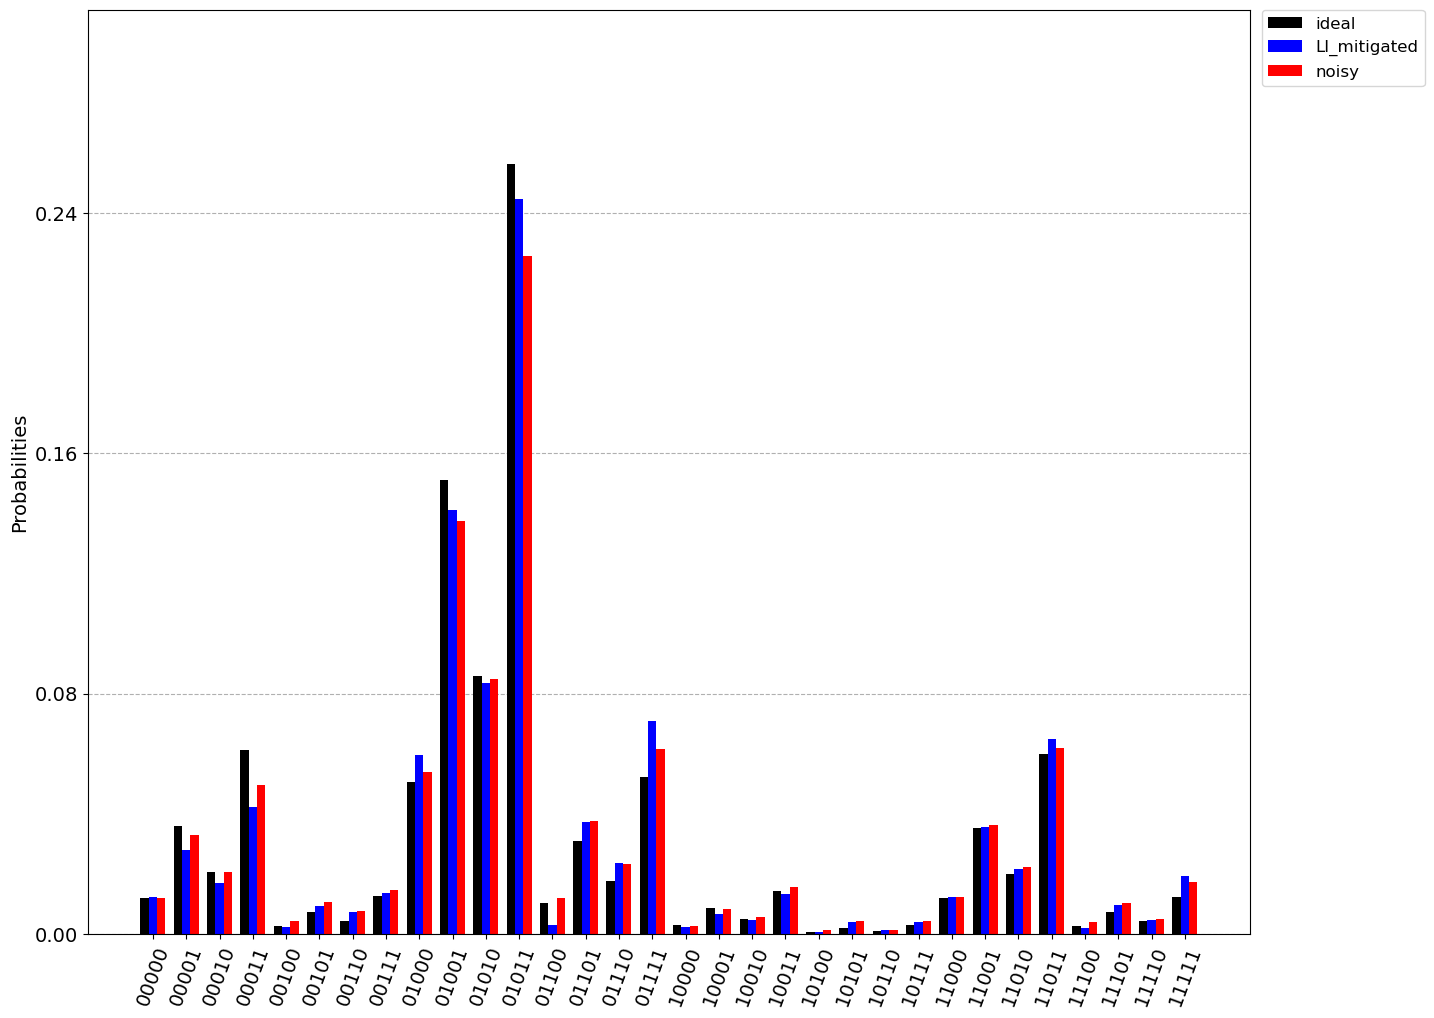

In [5]:
plot_histogram([Y.iloc[0], LI.iloc[0], X.iloc[0]], legend=['ideal', 'LI_mitigated', 'noisy'], bar_labels = False, figsize = (15, 12), color=['black', 'blue', 'red'])

# hidden layer : 2, n_node : 3 * (2^5)

In [6]:
n_train_data = 4000
random_state = [99]

miti = []
trainX, testX, trainY, testY, train_LI_miti, test_LI_miti = get_train_test(X, Y, LI, n_train_data, random_state = 0)

model = NN_model(n_qubit = 5, n_hidden_layer = 2, n_nodes = 3, activation = 'selu')

adam = keras.optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
model.fit(train_LI_miti, trainY, epochs = 300, batch_size = 16)

miti.append(model.predict(test_LI_miti))
f = device_type + '_' + str(5) + 'qubits_model.h5'
model.save(f)                

unmitigated_res = []
LI_res = []
LI_NN_res = []

unmitigated_res.append(loss_function(testY.values, testX.values, n_qubits[0]))
LI_res.append(loss_function(testY.values, test_LI_miti.values, n_qubits[0]))
LI_NN_res.append(loss_function(testY.values, miti[0], n_qubits[0]))

Epoch 1/300
250/250 [==============================] - 1s 2ms/step - loss: 3.4029 - accuracy: 0.1582
Epoch 2/300
250/250 [==============================] - 0s 1ms/step - loss: 2.9704 - accuracy: 0.6339
Epoch 3/300
250/250 [==============================] - 0s 1ms/step - loss: 2.6135 - accuracy: 0.8285
Epoch 4/300
250/250 [==============================] - 0s 1ms/step - loss: 2.5493 - accuracy: 0.9014
Epoch 5/300
250/250 [==============================] - 0s 1ms/step - loss: 2.5429 - accuracy: 0.9234
Epoch 6/300
250/250 [==============================] - 0s 1ms/step - loss: 2.5363 - accuracy: 0.9353
Epoch 7/300
250/250 [==============================] - 0s 1ms/step - loss: 2.5358 - accuracy: 0.9276
Epoch 8/300
250/250 [==============================] - 0s 1ms/step - loss: 2.5386 - accuracy: 0.9389
Epoch 9/300
250/250 [==============================] - 0s 1ms/step - loss: 2.5325 - accuracy: 0.9342
Epoch 10/300
250/250 [==============================] - 0s 1ms/step - loss: 2.5286 - accura

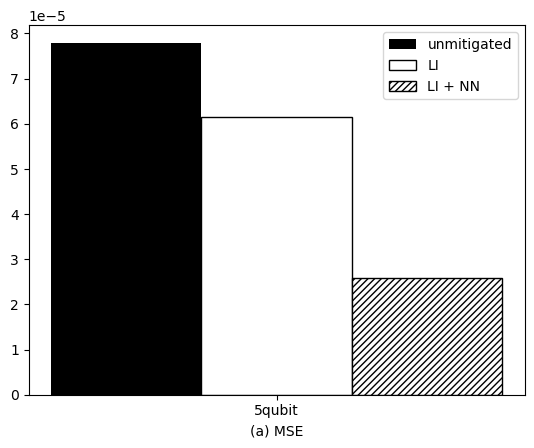

In [7]:
topics = ['5qubit']
label = ['unmitigated', 'LI', 'LI + NN']
show_plot(topics, unmitigated_res, LI_res, LI_NN_res, 0, label)

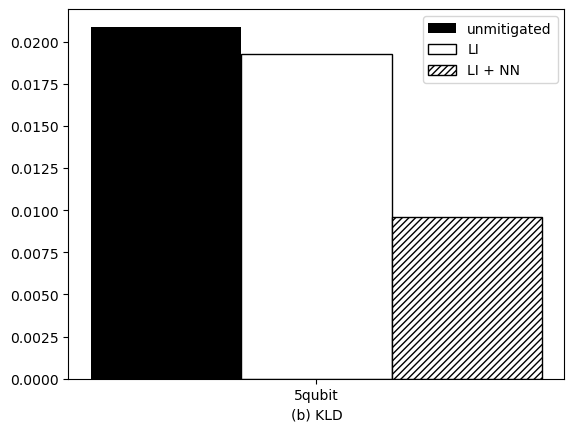

In [8]:
show_plot(topics, unmitigated_res, LI_res, LI_NN_res, 1, label)

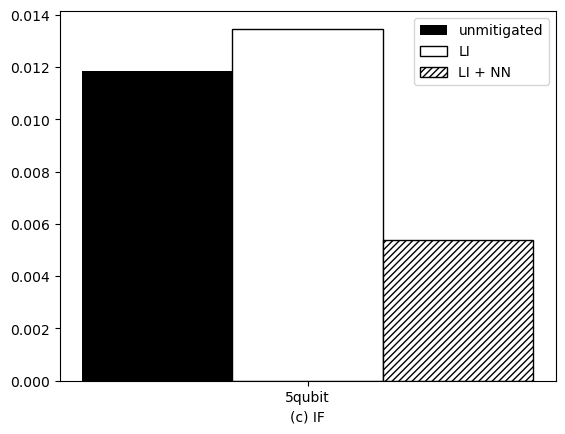

In [9]:
show_plot(topics, unmitigated_res, LI_res, LI_NN_res, 2, label)

# transfer learning

In [10]:
n_qubits = [5]
n_data = 300 
times = [15]
device_type = "ibm_geneva"
number = 1

#n_qubits = [5]
#n_data = 900 
#times = [5]
#device_type = 'ibmq_toronto'
#number = 1

another_device_type = "ibm_geneva"
another_number = 0

X, Y= load_data(n_qubits, n_data, times, device_type, number)
LI = LI_QREM(n_qubits[0], times[0], n_data, device_type, 0, X[0])

In [11]:
for i in range(len(n_qubits)):
    f = another_device_type + '_' + str(n_qubits[i]) + 'qubits_model.h5'
    model_t1 = load_model(f)

for layer in model_t1.layers:
    layer.trainable = False

model_t1.layers[3].trainable = True
model_t1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 96)                3168      
_________________________________________________________________
dense_1 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_2 (Dense)              (None, 96)                9312      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                3104      
Total params: 24,896
Trainable params: 3,104
Non-trainable params: 21,792
_________________________________________________________________


In [12]:
n_train_data = 4000
random_state = [77]
trainX, testX, trainY, testY, train_LI_miti, test_LI_miti = get_train_test(X[0], Y[0], LI, n_train_data, random_state = random_state[0])


In [13]:
adam = keras.optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model_t1.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = 'acc')
h = model_t1.fit(train_LI_miti, trainY, epochs = 300, batch_size = 16)

miti_1 = []
x = model_t1.predict(test_LI_miti)
miti_1.append(x)


Epoch 1/300
250/250 [==============================] - 0s 558us/step - loss: 2.5575 - acc: 0.8620
Epoch 2/300
250/250 [==============================] - 0s 717us/step - loss: 2.5263 - acc: 0.9278
Epoch 3/300
250/250 [==============================] - 0s 552us/step - loss: 2.5179 - acc: 0.9274
Epoch 4/300
250/250 [==============================] - 0s 677us/step - loss: 2.5029 - acc: 0.9256
Epoch 5/300
250/250 [==============================] - 0s 564us/step - loss: 2.5145 - acc: 0.9181
Epoch 6/300
250/250 [==============================] - 0s 565us/step - loss: 2.5112 - acc: 0.9247
Epoch 7/300
250/250 [==============================] - 0s 586us/step - loss: 2.5189 - acc: 0.9256
Epoch 8/300
250/250 [==============================] - 0s 535us/step - loss: 2.4941 - acc: 0.9249
Epoch 9/300
250/250 [==============================] - 0s 598us/step - loss: 2.5057 - acc: 0.9289
Epoch 10/300
250/250 [==============================] - 0s 517us/step - loss: 2.5103 - acc: 0.9296
Epoch 11/300
250/25

In [14]:
miti_2 = []
model_t2 = NN_model(n_qubit = 5, n_hidden_layer = 2, n_nodes = 3, activation = 'selu')

adam = keras.optimizers.Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
model_t2.compile(loss='categorical_crossentropy', optimizer = adam, metrics=['accuracy'])
model_t2.fit(train_LI_miti, trainY, epochs = 300, batch_size = 16)

miti_2.append(model_t2.predict(test_LI_miti))


Epoch 1/300
250/250 [==============================] - 1s 920us/step - loss: 3.3962 - accuracy: 0.1497
Epoch 2/300
250/250 [==============================] - 0s 913us/step - loss: 2.9834 - accuracy: 0.5565
Epoch 3/300
250/250 [==============================] - 0s 904us/step - loss: 2.6391 - accuracy: 0.8020
Epoch 4/300
250/250 [==============================] - 0s 896us/step - loss: 2.5622 - accuracy: 0.8913
Epoch 5/300
250/250 [==============================] - 0s 843us/step - loss: 2.5407 - accuracy: 0.9067
Epoch 6/300
250/250 [==============================] - 0s 802us/step - loss: 2.5462 - accuracy: 0.9241
Epoch 7/300
250/250 [==============================] - 0s 857us/step - loss: 2.5342 - accuracy: 0.9198
Epoch 8/300
250/250 [==============================] - 0s 831us/step - loss: 2.5371 - accuracy: 0.9162
Epoch 9/300
250/250 [==============================] - 0s 881us/step - loss: 2.5323 - accuracy: 0.9283
Epoch 10/300
250/250 [==============================] - 0s 830us/step - l

In [15]:
NN_res2 = []
unmitigated_res2 = []
transfer_res2 = []


unmitigated_res2.append(loss_function(testY.values, testX.values, n_qubits[0]))
NN_res2.append(loss_function(testY.values, miti_2[0], n_qubits[0]))
transfer_res2.append(loss_function(testY.values, miti_1[0], n_qubits[0]))


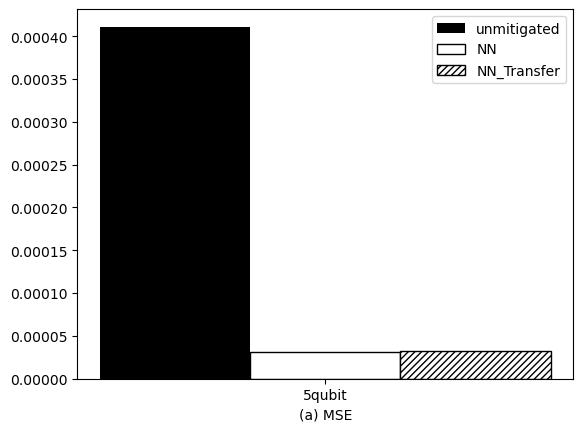

In [16]:
topics = ['5qubit']
label = ['unmitigated', 'NN', 'NN_Transfer']
show_plot(topics, unmitigated_res2, NN_res2, transfer_res2, 0, label)

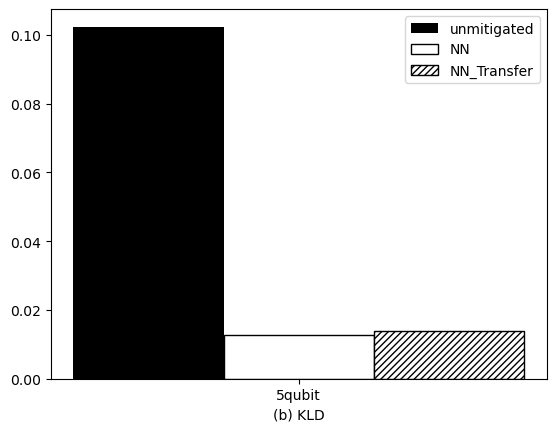

In [17]:
show_plot(topics, unmitigated_res2, NN_res2, transfer_res2, 1, label)

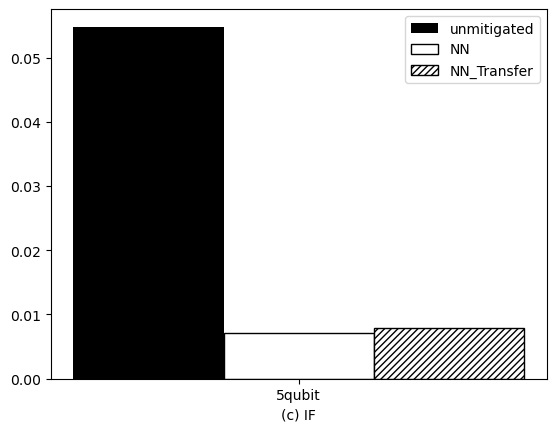

In [18]:
show_plot(topics, unmitigated_res2, NN_res2, transfer_res2, 2, label)